### Library Imports

In [1]:
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import random
from skimage import exposure
import matplotlib.pyplot as plt
import rasterio

from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, FunctionTransformer, OneHotEncoder, PowerTransformer
from sklearn.model_selection import StratifiedKFold, cross_val_predict, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.experimental import enable_iterative_imputer  # Required to enable IterativeImputer
from sklearn.impute import IterativeImputer, KNNImputer 
from sklearn.pipeline import Pipeline

from concurrent.futures import ThreadPoolExecutor, as_completed
from joblib import Parallel, delayed
import logging
from shapely import wkt
from shapely.geometry import Polygon, MultiPolygon
from shapely.affinity import scale, translate
import geemap
import ee
import shutil
import geemap
from tqdm import tqdm

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

### Google Earth Engine Setup

In [2]:
# ee.Authenticate()
# ee.Initialize(project="my-project-1-398612")

In [3]:
# print(os.environ)

### Loading and preparing data

In [4]:
file_path = r"C:\Users\USER\Downloads\Telangana_crop_health_challenge\Train.csv"
# Read the CSV file
train = pd.read_csv(file_path)

# Print the first 5 rows
train.head()

,FarmID,category,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,CHeight,CNext,CLast,CTransp,IrriType,IrriSource,IrriCount,WaterCov,ExpYield,Season,geometry
0,1326576,Healthy,Paddy,Telangana,Medak,Kulcharam,25-11-2023,14-04-2024,97,54,Pea,Lentil,Transplanting,Flood,Groundwater,4,87,17,Rabi,POLYGON ((78.18143246076087 17.978884603571068...
1,1326577,Healthy,Paddy,Telangana,Medak,Kulcharam,13-11-2023,26-04-2024,82,58,Pea,Lentil,Transplanting,Flood,Canal,5,94,15,Rabi,POLYGON ((78.17545177547453 17.981074445477304...
2,1326578,Healthy,Paddy,Telangana,Medak,Kulcharam,19-12-2023,28-04-2024,92,91,Pea,Lentil,Transplanting,Flood,Canal,3,99,20,Rabi,POLYGON ((78.16914224770792 17.976212849967755...
3,1331836,Diseased,Paddy,Telangana,Medak,Kulcharam,11-02-2023,04-11-2024,91,52,Pea,Lentil,Transplanting,Flood,Canal,5,92,16,Rabi,POLYGON ((78.16889103841902 17.974608186550842...
4,1326579,Diseased,Paddy,Telangana,Medak,Kulcharam,12-12-2023,19-05-2024,94,55,Pea,Lentil,Transplanting,Flood,Canal,5,97,20,Rabi,POLYGON ((78.17264452998072 17.969251496349454...


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8775 entries, 0 to 8774
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   FarmID           8775 non-null   int64 
 1   category         8775 non-null   object
 2   Crop             8775 non-null   object
 3   State            8775 non-null   object
 4   District         8775 non-null   object
 5   Sub-District     8775 non-null   object
 6   SDate            8775 non-null   object
 7   HDate            8775 non-null   object
 8   CropCoveredArea  8775 non-null   int64 
 9   CHeight          8775 non-null   int64 
 10  CNext            8775 non-null   object
 11  CLast            8775 non-null   object
 12  CTransp          8775 non-null   object
 13  IrriType         8775 non-null   object
 14  IrriSource       8775 non-null   object
 15  IrriCount        8775 non-null   int64 
 16  WaterCov         8775 non-null   int64 
 17  ExpYield         8775 non-null   

In [6]:
file_path2 = r"C:\Users\USER\Downloads\Telangana_crop_health_challenge\Test.csv"
# Read the CSV file
test = pd.read_csv(file_path2)

# Print the first 5 rows
test.head()

,FarmID,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,CHeight,CNext,CLast,CTransp,IrriType,IrriSource,IrriCount,WaterCov,ExpYield,Season,geometry
0,85197,Paddy,Telangana,Medak,Nizampet,12-11-2023,14-05-2024,81,99,Lentil,Pea,Transplanting,Flood,Groundwater,5,81,19,Rabi,POLYGON ((78.54742059207287 18.062307326758276...
1,779677,Paddy,Telangana,Medak,Nizampet,20-12-2023,28-05-2024,91,63,Lentil,Pea,Transplanting,Flood,Canal,5,97,15,Rabi,"POLYGON ((78.54812514990353 18.06739449795583,..."
2,1331840,Paddy,Telangana,Medak,Nizampet,29-11-2023,18-05-2024,94,89,Pea,Lentil,Transplanting,Flood,Canal,5,88,15,Rabi,POLYGON ((78.56002792938853 18.079607077817514...
3,483053,Paddy,Telangana,Medak,Nizampet,11-01-2023,27-04-2024,83,78,Pea,Lentil,Transplanting,Flood,Canal,5,98,17,Rabi,POLYGON ((78.56216943364733 18.081207346902854...
4,542945,Paddy,Telangana,Medak,Nizampet,11-04-2023,25-04-2024,82,53,Lentil,Pea,Transplanting,Flood,Canal,6,98,18,Rabi,POLYGON ((78.56844746870425 18.084730868444957...


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3016 entries, 0 to 3015
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   FarmID           3016 non-null   int64 
 1   Crop             3016 non-null   object
 2   State            3016 non-null   object
 3   District         3016 non-null   object
 4   Sub-District     3016 non-null   object
 5   SDate            3016 non-null   object
 6   HDate            3016 non-null   object
 7   CropCoveredArea  3016 non-null   int64 
 8   CHeight          3016 non-null   int64 
 9   CNext            3016 non-null   object
 10  CLast            3016 non-null   object
 11  CTransp          3016 non-null   object
 12  IrriType         3016 non-null   object
 13  IrriSource       3016 non-null   object
 14  IrriCount        3016 non-null   int64 
 15  WaterCov         3016 non-null   int64 
 16  ExpYield         3016 non-null   int64 
 17  Season           3016 non-null   

##### Convert Geometry Columns to Geospatial Format

In [8]:
# Convert WKT geometry to actual geometry objects
train['geometry'] = train['geometry'].apply(wkt.loads)
test['geometry'] = test['geometry'].apply(wkt.loads)

##### Convert DataFrames to GeoDataFrames

In [9]:
# Convert to GeoDataFrames
train = gpd.GeoDataFrame(train, crs='epsg:4326')
test = gpd.GeoDataFrame(test, crs='epsg:4326')

##### Concatenate Train and Test Data for Unified Processing

In [10]:
# Concatenate train and test datasets
data = pd.concat([train.assign(dataset='train'), test.assign(dataset='test')]).reset_index(drop=True)

In [11]:
data.head()

,FarmID,category,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,CHeight,...,CLast,CTransp,IrriType,IrriSource,IrriCount,WaterCov,ExpYield,Season,geometry,dataset
0,1326576,Healthy,Paddy,Telangana,Medak,Kulcharam,25-11-2023,14-04-2024,97,54,...,Lentil,Transplanting,Flood,Groundwater,4,87,17,Rabi,"POLYGON ((78.18143 17.97888, 78.18149 17.97899...",train
1,1326577,Healthy,Paddy,Telangana,Medak,Kulcharam,13-11-2023,26-04-2024,82,58,...,Lentil,Transplanting,Flood,Canal,5,94,15,Rabi,"POLYGON ((78.17545 17.98107, 78.17578 17.98104...",train
2,1326578,Healthy,Paddy,Telangana,Medak,Kulcharam,19-12-2023,28-04-2024,92,91,...,Lentil,Transplanting,Flood,Canal,3,99,20,Rabi,"POLYGON ((78.16914 17.97621, 78.1693 17.97619,...",train
3,1331836,Diseased,Paddy,Telangana,Medak,Kulcharam,11-02-2023,04-11-2024,91,52,...,Lentil,Transplanting,Flood,Canal,5,92,16,Rabi,"POLYGON ((78.16889 17.97461, 78.16916 17.97471...",train
4,1326579,Diseased,Paddy,Telangana,Medak,Kulcharam,12-12-2023,19-05-2024,94,55,...,Lentil,Transplanting,Flood,Canal,5,97,20,Rabi,"POLYGON ((78.17264 17.96925, 78.17276 17.96926...",train


##### Scale Geometry Object

In [12]:
# Function to scale each geometry around its centroid
def scale_geometry(geometry, scale_factor):
    """
    Scale a geometry object around its centroid.

    Parameters:
        geometry (shapely.geometry.base.BaseGeometry): Geometry to scale.
        scale_factor (float): Factor by which to scale the geometry.

    Returns:
        shapely.geometry.base.BaseGeometry: Scaled geometry object.
    """
    # Calculate centroid
    centroid = geometry.centroid
    # Translate geometry to origin
    translated_geometry = translate(geometry, -centroid.x, -centroid.y)
    # Scale geometry
    scaled_geometry = scale(translated_geometry, xfact=scale_factor, yfact=scale_factor, origin=(0, 0))
    # Translate back to the original centroid
    return translate(scaled_geometry, centroid.x, centroid.y)

In [13]:
# Scale the geometries
scale_factor = 5
data['geometry'] = data['geometry'].apply(scale_geometry, scale_factor=scale_factor)

### Download Image Data

##### Utils

In [14]:
from datetime import datetime
import warnings

# Function to format date strings to 'YYYY-MM-DD'
def format_date(date_str):
    """
    Convert date string to 'YYYY-MM-DD' format, temporarily catching any warnings.

    Parameters:
        date_str (str): Date in string format.

    Returns:
        str: Formatted date string in 'YYYY-MM-DD' format, or None if invalid.
    """
    if date_str is None:
        return None

    try:
        with warnings.catch_warnings(record=True):
            warnings.simplefilter("always")
            # Attempt parsing in 'YYYY-MM-DD' format
            date = datetime.strptime(date_str, "%Y-%m-%d")
            return date.strftime("%Y-%m-%d")

    except ValueError:
        # Attempt parsing in 'DD/MM/YYYY' format
        try:
            date = datetime.strptime(date_str, "%d/%m/%Y")
            return date.strftime("%Y-%m-%d")
        
        # Attempt parsing in 'DD-MM-YYYY' format
        except ValueError:
            try:
                date = datetime.strptime(date_str, "%d-%m-%Y")
                return date.strftime("%Y-%m-%d")
            
            except ValueError:
                print(f"Unrecognized date format for {date_str}")
                return None

# Convert date strings to correct format
data['SDate'] = data['SDate'].apply(format_date)
data['HDate'] = data['HDate'].apply(format_date)


##### Download from Earth Engine

In [15]:
# Define the `download` variable
download = False  # Set to True to download images, False to load existing data

##### Set Up Directories

In [16]:
# # Initialize Earth Engine
# ee.Initialize()

# # Remove existing 'downloads' folder if it exists
# if os.path.exists('downloads'):
#     os.system('rm -rf downloads')

In [17]:
# Ensure the output directory exists
output_folder = 'downloads'
os.makedirs(output_folder, exist_ok=True)

In [18]:
# Function to download RGB images from Earth Engine
def download_rgb_image(collection_name, bands, start_date, end_date, region, output_folder='downloads'):
    """Download RGB bands from a GEE collection filtered by date and region."""
    # Load the image collection, filter by date, and clip to region
    collection = ee.ImageCollection(collection_name).filterDate(start_date, end_date).filterBounds(region)
    image = collection.sort('system:time_start', False).first().select(bands).clip(region)  # Most recent image

    # Define unique filename based on image dates
    image_id = image.id().getInfo() or f'image_{start_date}_{end_date}'
    image_name = f'{output_folder}/{image_id}_RGB_{start_date}_{end_date}.tif'

    # Export the image to a GeoTIFF file
    geemap.ee_export_image(
        image,
        filename=image_name,
        scale=10,  # Sentinel-2 resolution in meters
        region=region,
        file_per_band=False,  # Save as a multi-band TIFF
        crs='EPSG:4326'
    )
    print(f"Downloaded: {image_name}")
    return image_name

In [19]:
def process_row(index, row, image_collection_name, bands, output_folder):
    """
    Processes a row of data, downloads an image, and updates the DataFrame.

    Args:
        index (int): Index of the row in the DataFrame.
        row (pandas.Series): A row of data from the DataFrame.
        image_collection_name (str): Name of the Earth Engine image collection.
        bands (list[str]): List of bands to download from the image collection.
        output_folder (str): Path to the output folder for downloaded images.

    Returns:
        tuple: A tuple containing the index and downloaded image file path (or 'download_failed').
    """

    try:
        # Format date strings
        start_date = format_date(row['SDate'])
        end_date = format_date(row['HDate'])

        # Skip rows with invalid dates
        if not start_date or not end_date:
            print(f"Skipping entry due to invalid dates: SDate={row['SDate']}, HDate={row['HDate']}")
            return index, None

        # Extract and check geometry
        region_geometry = row['geometry']
        district = row['District']

        # Skip rows with empty or unsupported geometry types
        if region_geometry.is_empty:
            print(f"Skipping entry due to empty geometry for District: {district}")
            return index, None

        # Convert geometry to EE format
        if region_geometry.geom_type == 'Polygon':
            region = ee.Geometry.Polygon(region_geometry.__geo_interface__['coordinates'])
        elif region_geometry.geom_type == 'MultiPolygon':
            coords = [polygon.exterior.coords[:] for polygon in region_geometry.geoms]
            region = ee.Geometry.MultiPolygon(coords)
        else:
            print(f"Skipping unsupported geometry type: {region_geometry.geom_type} for District: {district}")
            return index, None
            
        # Download the image
        image_file = download_rgb_image(image_collection_name, bands, start_date, end_date, region, output_folder)

        if image_file:
            data.at[index, 'tif_path'] = image_file
            print(f"Downloaded image for row {index}: {image_file}")
            return index, image_file
        else:
            print(f"Failed to download image for row {index}")
            return index, None

    except Exception as e:
        print(f"Error processing row {index}: {e}")
        # Consider more specific error handling if needed
        data.at[index, 'tif_path'] = 'download_failed'
        return index, 'download_failed'

In [20]:
    # Define Sentinel-2 collection and bands
    image_collection_name = 'COPERNICUS/S2'
    bands = ['B4', 'B3', 'B2', 'B8', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12']

In [21]:
if download:
    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = [
            executor.submit(process_row, index, row, image_collection_name, bands, output_folder)
            for index, row in data.iterrows()
        ]
        results = {future.result()[0]: future.result()[1] for future in as_completed(futures)}

    # Update the DataFrame with paths
    for idx, image_path in results.items():
        data.at[idx, 'tif_path'] = image_path

else:
    try:
        # Copy the downloads folder to the current directory if not already present
        if not os.path.exists('./downloads'):
            shutil.copytree(r'C:\Users\USER\Downloads\Telangana_crop_health_challenge\downloads', './downloads')
        
        # Set the data path explicitly
        data_path = r"C:\Users\USER\Downloads\telangana-crop-health-challenge\data.csv"
        
        # Load the existing data
        if os.path.exists(data_path):
            data = pd.read_csv(data_path)
            print("Data loaded successfully:")
            print(data.head())
        else:
            raise FileNotFoundError(f"The data file does not exist at {data_path}")
    except Exception as e:
        print(f"Error loading existing data: {e}")


Data loaded successfully:
    FarmID  category   Crop      State District Sub-District       SDate  \
0  1326576   Healthy  Paddy  Telangana    Medak    Kulcharam  2023-11-25   
1  1326577   Healthy  Paddy  Telangana    Medak    Kulcharam  2023-11-13   
2  1326578   Healthy  Paddy  Telangana    Medak    Kulcharam  2023-12-19   
3  1331836  Diseased  Paddy  Telangana    Medak    Kulcharam  2023-02-11   
4  1326579  Diseased  Paddy  Telangana    Medak    Kulcharam  2023-12-12   

        HDate  CropCoveredArea  CHeight  ...        CTransp IrriType  \
0  2024-04-14               97       54  ...  Transplanting    Flood   
1  2024-04-26               82       58  ...  Transplanting    Flood   
2  2024-04-28               92       91  ...  Transplanting    Flood   
3  2024-11-04               91       52  ...  Transplanting    Flood   
4  2024-05-19               94       55  ...  Transplanting    Flood   

    IrriSource IrriCount WaterCov  ExpYield  Season  \
0  Groundwater         4     

In [22]:
# if download:
#     with ThreadPoolExecutor(max_workers=4) as executor:
#         futures = [
#             executor.submit(process_row, index, row, image_collection_name, bands, output_folder)
#             for index, row in data.iterrows()
#         ]
#         results = {future.result()[0]: future.result()[1] for future in as_completed(futures)}

#     # Update the DataFrame with paths
#     for idx, image_path in results.items():
#         data.at[idx, 'tif_path'] = image_path

# else:
#     try:
#         shutil.copytree('/Users/USER/Downloads/Telangana_crop_health_challenge/downloads', '.')
#         data_path = 'data.csv'
#         data = pd.read_csv(data_path)
#     except Exception as e:
#         print(f"Error loading existing data: {e}")

In [23]:
data.head()

,FarmID,category,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,CHeight,...,CTransp,IrriType,IrriSource,IrriCount,WaterCov,ExpYield,Season,geometry,dataset,tif_path
0,1326576,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-11-25,2024-04-14,97,54,...,Transplanting,Flood,Groundwater,4,87,17,Rabi,POLYGON ((78.18079255482755 17.978971746424413...,train,downloads/20240412T050649_20240412T051727_T43Q...
1,1326577,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-11-13,2024-04-26,82,58,...,Transplanting,Flood,Canal,5,94,15,Rabi,POLYGON ((78.17483419891283 17.981508840879556...,train,downloads/20240425T051649_20240425T052817_T43Q...
2,1326578,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-12-19,2024-04-28,92,91,...,Transplanting,Flood,Canal,3,99,20,Rabi,POLYGON ((78.16888476438905 17.976727511659835...,train,downloads/20240427T050651_20240427T051439_T43Q...
3,1331836,Diseased,Paddy,Telangana,Medak,Kulcharam,2023-02-11,2024-11-04,91,52,...,Transplanting,Flood,Canal,5,92,16,Rabi,POLYGON ((78.16821795882959 17.974690113471414...,train,downloads/20241103T050951_20241103T052004_T43Q...
4,1326579,Diseased,Paddy,Telangana,Medak,Kulcharam,2023-12-12,2024-05-19,94,55,...,Transplanting,Flood,Canal,5,97,20,Rabi,POLYGON ((78.17244459940454 17.969620948965225...,train,downloads/20240517T050651_20240517T051655_T43Q...


In [24]:
data.tail()

,FarmID,category,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,CHeight,...,CTransp,IrriType,IrriSource,IrriCount,WaterCov,ExpYield,Season,geometry,dataset,tif_path
11786,551119,NaN,Maize,Telangana,Nirmal,Sarangapur,2023-10-12,2024-07-03,92,225,...,Drilling,Drip,Groundwater,4,44,39,Rabi,"POLYGON ((78.25900010978795 19.22927351046702,...",test,downloads/20240701T050659_20240701T051520_T43Q...
11787,916476,NaN,Maize,Telangana,Nirmal,Sarangapur,2023-05-11,2024-04-03,79,236,...,Seed Drilling,Drip,Canal,3,41,40,Rabi,POLYGON ((78.25818808460964 19.202014687110104...,test,downloads/20240402T050649_20240402T051718_T43Q...
11788,121860,NaN,Maize,Telangana,Nirmal,Sarangapur,2023-11-14,2024-03-04,87,210,...,Broadcasting,Sprinkler,Canal,3,43,41,Rabi,"POLYGON ((78.2554603258883 19.19636630652319, ...",test,downloads/20240303T050719_20240303T051936_T43Q...
11789,270936,NaN,Maize,Telangana,Nirmal,Sarangapur,2023-02-12,2024-03-26,95,204,...,Drilling,Sprinkler,Canal,4,48,39,Rabi,POLYGON ((78.25742756428231 19.195573453548704...,test,downloads/20240323T050649_20240323T051727_T43Q...
11790,1326552,NaN,Maize,Telangana,Nirmal,Sarangapur,2023-11-23,2024-03-22,78,185,...,Broadcasting,Drip,Canal,2,52,41,Rabi,POLYGON ((78.26473996074711 19.225096392031386...,test,downloads/20240321T051651_20240321T053116_T43Q...


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11791 entries, 0 to 11790
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   FarmID           11791 non-null  int64 
 1   category         8775 non-null   object
 2   Crop             11791 non-null  object
 3   State            11791 non-null  object
 4   District         11791 non-null  object
 5   Sub-District     11791 non-null  object
 6   SDate            11791 non-null  object
 7   HDate            11791 non-null  object
 8   CropCoveredArea  11791 non-null  int64 
 9   CHeight          11791 non-null  int64 
 10  CNext            11791 non-null  object
 11  CLast            11791 non-null  object
 12  CTransp          11791 non-null  object
 13  IrriType         11791 non-null  object
 14  IrriSource       11791 non-null  object
 15  IrriCount        11791 non-null  int64 
 16  WaterCov         11791 non-null  int64 
 17  ExpYield         11791 non-null

#### Visualisation

In [26]:
# Function to scale pixel values to the 0–255 range for better visualization
def scale_band(band):
    """
    Scales pixel values of a single band to the 0-255 range.

    Parameters:
    - band: np.array, pixel values of the band

    Returns:
    - np.array, scaled pixel values in the 0-255 range
    """
    band = band.astype(np.float32)  # Ensure values are in float for scaling
    return 255 * (band - np.min(band)) / (np.max(band) - np.min(band))  # Scale to 0–255

# Function to visualize RGB image with scaling, contrast adjustments, and optional gamma correction
def visualize_rgb_image(file_path, gamma=0.6, contrast_stretch=True):
    """
    Visualize an RGB image using matplotlib with scaling, optional gamma correction, and contrast stretching.

    Parameters:
    - file_path: str, path to the RGB image file (GeoTIFF)
    - gamma: float, gamma correction factor (default=0.6)
    - contrast_stretch: bool, whether to apply contrast stretching (default=True)
    """
    # Open the image file
    with rasterio.open(file_path) as src:
        # Read RGB bands (assuming Sentinel-2 band order: Red=B4, Green=B3, Blue=B2)
        red = src.read(3)  # Band 4 for Red
        green = src.read(2)  # Band 3 for Green
        blue = src.read(1)  # Band 2 for Blue

        # Scale each band to the 0–255 range for better visualization
        red_scaled = scale_band(red)
        green_scaled = scale_band(green)
        blue_scaled = scale_band(blue)

        # Stack the scaled RGB bands into a single image
        rgb = np.dstack((red_scaled, green_scaled, blue_scaled)).astype(np.uint8)

        # Apply contrast stretching if specified
        if contrast_stretch:
            p2, p98 = np.percentile(rgb, (2, 98))  # Calculate 2nd and 98th percentiles for stretching
            rgb = exposure.rescale_intensity(rgb, in_range=(p2, p98))

        # Apply gamma correction to adjust brightness
        rgb = exposure.adjust_gamma(rgb, gamma=gamma)

        # Display the processed image using matplotlib
        plt.figure(figsize=(5, 5))
        plt.imshow(rgb)
        plt.axis('off')  # Hide axes for a cleaner look
        plt.title("RGB Composite (Red-Green-Blue) with Scaling, Contrast Stretch, and Gamma Correction")
        plt.show()

    return rgb

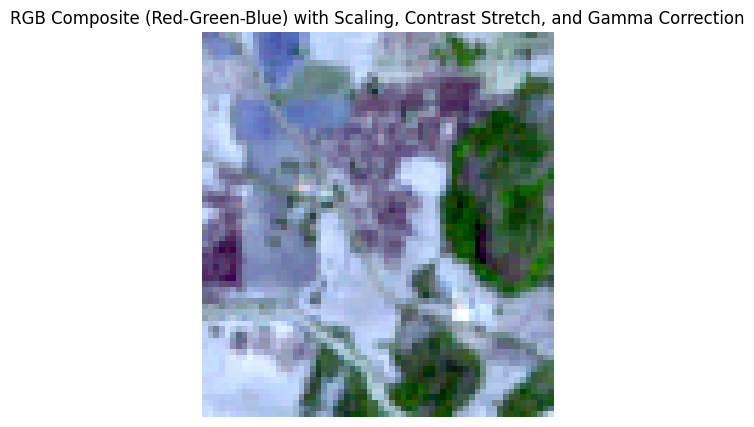

In [27]:
# Select a random image file from the dataset and visualize it
path = random.choice(data['tif_path'].values)
image = visualize_rgb_image(path)

#### Feature Engineering

In [28]:
# Example feature calculation functions
def calculate_ndvi(nir_band, red_band):
    """Calculate NDVI (Normalized Difference Vegetation Index)."""
    ndvi = (nir_band - red_band) / (nir_band + red_band)
    return np.nanmean(ndvi)

def calculate_evi(nir_band, red_band, blue_band):
    """Calculate EVI (Enhanced Vegetation Index)."""
    evi = 2.5 * (nir_band - red_band) / (nir_band + 6 * red_band - 7.5 * blue_band + 1)
    return np.nanmean(evi)

def calculate_ndwi(nir_band, green_band):
    """Calculate NDWI (Normalized Difference Water Index)."""
    ndwi = (green_band - nir_band) / (green_band + nir_band)
    return np.nanmean(ndwi)

def calculate_gndvi(nir_band, green_band):
    """Calculate GNDVI (Green Normalized Difference Vegetation Index)."""
    gndvi = (nir_band - green_band) / (nir_band + green_band)
    return np.nanmean(gndvi)

def calculate_savi(nir_band, red_band, L=0.5):
    """Calculate SAVI (Soil Adjusted Vegetation Index)."""
    savi = ((nir_band - red_band) / (nir_band + red_band + L)) * (1 + L)
    return np.nanmean(savi)

def calculate_msavi(nir_band, red_band):
    """Calculate MSAVI (Modified Soil Adjusted Vegetation Index)."""
    msavi = (2 * nir_band + 1 - np.sqrt((2 * nir_band + 1)**2 - 8 * (nir_band - red_band))) / 2
    return np.nanmean(msavi)

In [29]:
# Function to calculate features for each row in the data
def process_row_for_features(index, row):
    features = {'index': index}

    # Retrieve the TIFF file path and check if it's valid
    tif_path = row['tif_path']
    if not isinstance(tif_path, str) or not os.path.exists(tif_path):
        print(f"Skipping entry due to missing or invalid tif_path for index {index}")
        # Add NaN for all features if path is invalid
        features.update({
            'ndvi': np.nan,
            'evi': np.nan,
            'ndwi': np.nan,
            'gndvi': np.nan,
            'savi': np.nan,
            'msavi': np.nan
        })
        return features

    # Open the TIFF file and read bands for feature calculation
    try:
        with rasterio.open(tif_path) as src:
            red = src.read(3)    # B4 for Red
            green = src.read(2)  # B3 for Green
            blue = src.read(1)   # B2 for Blue
            nir = src.read(4)    # B8 for NIR

            # Calculate each feature
            features['ndvi'] = calculate_ndvi(nir, red)
            features['evi'] = calculate_evi(nir, red, blue)
            features['ndwi'] = calculate_ndwi(nir, green)
            features['gndvi'] = calculate_gndvi(nir, green)
            features['savi'] = calculate_savi(nir, red)
            features['msavi'] = calculate_msavi(nir, red)

    except Exception as e:
        print(f"Error processing {tif_path} for index {index}: {e}")
        features.update({
            'ndvi': np.nan,
            'evi': np.nan,
            'ndwi': np.nan,
            'gndvi': np.nan,
            'savi': np.nan,
            'msavi': np.nan
        })
    return features

In [30]:
# Calculate features in parallel, controlling progress bar behavior
new_features = Parallel(n_jobs=-1)(delayed(process_row_for_features)(index, row)
                                   for index, row in tqdm(data.iterrows(), total=len(data), position=0, leave=True))

100%|████████████████████████████████████████████████████████████████████████████| 11791/11791 [03:45<00:00, 52.24it/s]


In [31]:
# Merge new features with the data
new_features_df = pd.DataFrame(new_features).set_index('index')
data = data.join(new_features_df)

In [32]:
data.head()

,FarmID,category,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,CHeight,...,Season,geometry,dataset,tif_path,ndvi,evi,ndwi,gndvi,savi,msavi
0,1326576,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-11-25,2024-04-14,97,54,...,Rabi,POLYGON ((78.18079255482755 17.978971746424413...,train,downloads/20240412T050649_20240412T051727_T43Q...,0.100756,-0.793684,8.488031,0.127153,0.151125,4232.596191
1,1326577,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-11-13,2024-04-26,82,58,...,Rabi,POLYGON ((78.17483419891283 17.981508840879556...,train,downloads/20240425T051649_20240425T052817_T43Q...,0.188090,0.564248,11.493762,0.187815,0.282110,3249.392822
2,1326578,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-12-19,2024-04-28,92,91,...,Rabi,POLYGON ((78.16888476438905 17.976727511659835...,train,downloads/20240427T050651_20240427T051439_T43Q...,0.206596,-1.456745,10.166884,0.206553,0.309869,3741.956055
3,1331836,Diseased,Paddy,Telangana,Medak,Kulcharam,2023-02-11,2024-11-04,91,52,...,Rabi,POLYGON ((78.16821795882959 17.974690113471414...,train,downloads/20241103T050951_20241103T052004_T43Q...,0.206250,2.206184,10.446196,0.220995,0.309350,3673.396729
4,1326579,Diseased,Paddy,Telangana,Medak,Kulcharam,2023-12-12,2024-05-19,94,55,...,Rabi,POLYGON ((78.17244459940454 17.969620948965225...,train,downloads/20240517T050651_20240517T051655_T43Q...,0.179721,-0.743638,8.665929,0.160657,0.269563,4227.338379


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11791 entries, 0 to 11790
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   FarmID           11791 non-null  int64  
 1   category         8775 non-null   object 
 2   Crop             11791 non-null  object 
 3   State            11791 non-null  object 
 4   District         11791 non-null  object 
 5   Sub-District     11791 non-null  object 
 6   SDate            11791 non-null  object 
 7   HDate            11791 non-null  object 
 8   CropCoveredArea  11791 non-null  int64  
 9   CHeight          11791 non-null  int64  
 10  CNext            11791 non-null  object 
 11  CLast            11791 non-null  object 
 12  CTransp          11791 non-null  object 
 13  IrriType         11791 non-null  object 
 14  IrriSource       11791 non-null  object 
 15  IrriCount        11791 non-null  int64  
 16  WaterCov         11791 non-null  int64  
 17  ExpYield    

In [34]:
unique_counts = data['tif_path'].value_counts()
print(unique_counts)

tif_path
download_failed                                                                   1196
downloads/20240522T050649_20240522T051545_T43QHA_RGB_2023-08-11_2024-05-25.tif       4
downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-06-17_2023-10-26.tif       3
downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-11-14_2024-04-16.tif       3
downloads/20231229T051221_20231229T052219_T43QHB_RGB_2023-07-22_2023-12-31.tif       3
                                                                                  ... 
downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-11-18_2024-11-04.tif       1
downloads/20240301T051741_20240301T053320_T43QHB_RGB_2023-11-29_2024-03-04.tif       1
downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-11-29_2024-03-25.tif       1
downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-11-12_2024-03-26.tif       1
downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-11-23_2024-03-22.tif       1
Name: count, Length: 10037, dtype:

In [35]:
# Get unique values for each column
unique_values = {col: data[col].unique() for col in data.columns}

# Display the unique values count for each column
unique_counts = {col: data[col].nunique() for col in data.columns}

# Print the unique values and their counts
for col in data.columns:
    print(f"Feature: {col}")
    print(f"Unique Values ({unique_counts[col]}): {unique_values[col]}")
    print("-" * 50)

Feature: FarmID
Unique Values (11791): [1326576 1326577 1326578 ...  121860  270936 1326552]
--------------------------------------------------
Feature: category
Unique Values (4): ['Healthy' 'Diseased' 'Pests' 'Stressed' nan]
--------------------------------------------------
Feature: Crop
Unique Values (7): ['Paddy' 'Cotton' 'Maize' 'Bengal Gram' 'Groundnut' 'Chillies' 'Red Gram']
--------------------------------------------------
Feature: State
Unique Values (1): ['Telangana']
--------------------------------------------------
Feature: District
Unique Values (16): ['Medak' 'Siddipet' 'Adilabad' 'Nirmal' 'Mahabubnagar' 'Nagarkurnool'
 'Narayanpet' 'Vikarabad' 'Wanaparthy' 'Nalgonda' 'Kamareddy'
 'Mahabubabad' 'Khammam' 'Warangal' 'Sangareddy' 'Kumurambheem Asifabad']
--------------------------------------------------
Feature: Sub-District
Unique Values (151): ['Kulcharam' 'Kowdipally' 'Chilipched' 'Narsapur' 'Yeldurthy' 'Medak'
 'Chegunta' 'Doultabad' 'Ramayampet' 'Shankarampet_A' 'M

In [36]:
# create irrigation efficiency feature
data['IrriEfficiency'] = data['WaterCov'] / (data['IrriCount'] + 1)  # Avoid division by zero

In [37]:
# Drop state column as it is just one state
data.drop(columns=['State'], inplace=True)

In [38]:
# Define helper functions
def process_dates(df):
    """
    Process SDate and HDate to extract meaningful features.
    """
    # Convert dates to datetime
    df['SDate'] = pd.to_datetime(df['SDate'], errors='coerce')
    df['HDate'] = pd.to_datetime(df['HDate'], errors='coerce')
    
    # Extract features
    df['SYear'] = df['SDate'].dt.year
    df['HYear'] = df['HDate'].dt.year
    df['Duration'] = (df['HDate'] - df['SDate']).dt.days  # Calculate duration in days

    # Crop Cycles Per Year
    df['CropCycles'] = 365 / df['Duration']

    # Drop original date columns
    df.drop(columns=['SDate', 'HDate', 'SYear', 'HYear'], inplace=True)
    return df

def preprocess_numerical_features(df, numerical_cols):
    """
    Scale numerical features and apply power transformation to make the features more Gaussian-like.
    """
    # Apply PowerTransformer to stabilize variance and normalize the data
    power_transformer = PowerTransformer()
    
    # Fit and transform the numerical features
    df[numerical_cols] = power_transformer.fit_transform(df[numerical_cols])

    # Return the transformed DataFrame
    return df

# def preprocess_numerical_features(df, numerical_cols):
#     """
#     Scale numerical features and log-transform skewed features.
#     """
#     # Log-transform skewed features
#     skewed_cols = df[numerical_cols].apply(lambda x: x.skew()).abs().sort_values(ascending=False)
#     skewed_cols = skewed_cols[skewed_cols > 1].index  # Columns with skewness > 1
#     df[skewed_cols] = df[skewed_cols].apply(lambda x: np.log1p(x))  # Log transform
    
#     # Scale numerical features
#     scaler = StandardScaler()
#     df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
#     return df


In [39]:
# --- Main workflow ---
# Process SDate and HDate
data = process_dates(data)

In [40]:
data.head(10)

,FarmID,category,Crop,District,Sub-District,CropCoveredArea,CHeight,CNext,CLast,CTransp,...,tif_path,ndvi,evi,ndwi,gndvi,savi,msavi,IrriEfficiency,Duration,CropCycles
0,1326576,Healthy,Paddy,Medak,Kulcharam,97,54,Pea,Lentil,Transplanting,...,downloads/20240412T050649_20240412T051727_T43Q...,0.100756,-0.793684,8.488031,0.127153,0.151125,4232.596191,17.400000,141,2.588652
1,1326577,Healthy,Paddy,Medak,Kulcharam,82,58,Pea,Lentil,Transplanting,...,downloads/20240425T051649_20240425T052817_T43Q...,0.188090,0.564248,11.493762,0.187815,0.282110,3249.392822,15.666667,165,2.212121
2,1326578,Healthy,Paddy,Medak,Kulcharam,92,91,Pea,Lentil,Transplanting,...,downloads/20240427T050651_20240427T051439_T43Q...,0.206596,-1.456745,10.166884,0.206553,0.309869,3741.956055,24.750000,131,2.786260
3,1331836,Diseased,Paddy,Medak,Kulcharam,91,52,Pea,Lentil,Transplanting,...,downloads/20241103T050951_20241103T052004_T43Q...,0.206250,2.206184,10.446196,0.220995,0.309350,3673.396729,15.333333,632,0.577532
4,1326579,Diseased,Paddy,Medak,Kulcharam,94,55,Pea,Lentil,Transplanting,...,downloads/20240517T050651_20240517T051655_T43Q...,0.179721,-0.743638,8.665929,0.160657,0.269563,4227.338379,16.166667,159,2.295597
5,1326580,Pests,Paddy,Medak,Kulcharam,97,51,Pea,Lentil,Transplanting,...,downloads/20240517T050651_20240517T051655_T43Q...,0.139147,-4.770755,10.018032,0.137413,0.208705,3599.652588,14.166667,157,2.324841
6,1326581,Healthy,Paddy,Medak,Kulcharam,84,68,Lentil,Pea,Transplanting,...,downloads/20240527T050651_20240527T051452_T43Q...,0.049956,-0.553626,8.664582,0.064934,0.074929,3914.587646,22.500000,192,1.901042
7,988392,Healthy,Paddy,Medak,Kulcharam,86,72,Pea,Lentil,Transplanting,...,downloads/20240402T050649_20240402T051718_T43Q...,0.211051,inf,10.583468,0.237314,0.316551,3667.590332,22.750000,112,3.258929
8,718074,Diseased,Paddy,Medak,Kulcharam,90,78,Pea,Lentil,Transplanting,...,downloads/20241004T050651_20241004T052234_T43Q...,0.101824,-26.822448,6.611994,0.117576,0.152728,5368.100098,21.500000,359,1.016713
9,214818,Healthy,Paddy,Medak,Kulcharam,90,53,Lentil,Pea,Transplanting,...,downloads/20240420T051651_20240420T052641_T43Q...,0.024438,-0.254345,3.808555,0.039830,0.036655,8770.608398,15.000000,193,1.891192


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11791 entries, 0 to 11790
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   FarmID           11791 non-null  int64  
 1   category         8775 non-null   object 
 2   Crop             11791 non-null  object 
 3   District         11791 non-null  object 
 4   Sub-District     11791 non-null  object 
 5   CropCoveredArea  11791 non-null  int64  
 6   CHeight          11791 non-null  int64  
 7   CNext            11791 non-null  object 
 8   CLast            11791 non-null  object 
 9   CTransp          11791 non-null  object 
 10  IrriType         11791 non-null  object 
 11  IrriSource       11791 non-null  object 
 12  IrriCount        11791 non-null  int64  
 13  WaterCov         11791 non-null  int64  
 14  ExpYield         11791 non-null  int64  
 15  Season           11791 non-null  object 
 16  geometry         11791 non-null  object 
 17  dataset     

In [42]:
# Split the data into train and test
train = data[data.dataset == 'train'].reset_index(drop=True)
test = data[data.dataset == 'test'].reset_index(drop=True)

In [43]:
# Define columns to drop
to_drop = ['geometry', 'tif_path', 'dataset', 'FarmID']

# Drop specified columns
train.drop(columns=to_drop, inplace=True)
test.drop(columns=to_drop, inplace=True)

In [44]:
# Combine for encoding
data_combined = pd.concat([train, test], ignore_index=True)

In [45]:
# Create a mapping for the target variable 'category' to numeric labels, excluding NaN values
category_mapper = {label: idx for idx, label in enumerate(data_combined['category'].unique()) if pd.notna(label)}
idx_to_category_mapper = {idx: label for idx, label in enumerate(data_combined['category'].unique()) if pd.notna(label)}

# Map the 'category' column to the new 'target' column using the mapping, handling NaN values as needed
data_combined['target'] = data_combined['category'].map(category_mapper)

# Drop the original 'category' column now that we have the 'target' column
data_combined.drop(columns=['category'], inplace=True)

##### Encoding of categorical columns

In [46]:
# Encode categorical columns
categorical_cols = data_combined.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    encoder = LabelEncoder()
    data_combined[col] = encoder.fit_transform(data_combined[col])
    label_encoders[col] = encoder

In [47]:
# Identify numerical columns
numerical_cols = data_combined.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('target')  # Exclude target variable

In [48]:
# Check for infinities or extremely large values
inf_cols = data_combined[numerical_cols].apply(lambda col: np.isinf(col).any())
print("Columns with infinity values:", inf_cols[inf_cols].index.tolist())

large_vals = data_combined[numerical_cols].apply(lambda col: (col > 1e308).any())
print("Columns with extremely large values:", large_vals[large_vals].index.tolist())


Columns with infinity values: ['evi', 'CropCycles']
Columns with extremely large values: ['evi', 'CropCycles']


In [49]:
# Replace inf or -inf values with NaN (to handle them later)
data_combined[numerical_cols] = data_combined[numerical_cols].replace([np.inf, -np.inf], np.nan)

In [50]:
# Cap or clip excessively large values
data_combined[numerical_cols] = data_combined[numerical_cols].clip(upper=1e308)

In [51]:
# Impute missing values using IterativeImputer
iterative_imputer = IterativeImputer(max_iter=50, random_state=0)
data_combined[numerical_cols] = iterative_imputer.fit_transform(data_combined[numerical_cols])

In [52]:
# Preprocess numerical features
data_combined = preprocess_numerical_features(data_combined, numerical_cols)

In [53]:
data_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11791 entries, 0 to 11790
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Crop             11791 non-null  int32  
 1   District         11791 non-null  int32  
 2   Sub-District     11791 non-null  int32  
 3   CropCoveredArea  11791 non-null  float64
 4   CHeight          11791 non-null  float64
 5   CNext            11791 non-null  int32  
 6   CLast            11791 non-null  int32  
 7   CTransp          11791 non-null  int32  
 8   IrriType         11791 non-null  int32  
 9   IrriSource       11791 non-null  int32  
 10  IrriCount        11791 non-null  float64
 11  WaterCov         11791 non-null  float64
 12  ExpYield         11791 non-null  float64
 13  Season           11791 non-null  int32  
 14  ndvi             11791 non-null  float64
 15  evi              11791 non-null  float64
 16  ndwi             11791 non-null  float64
 17  gndvi       

In [54]:
# Split back into train and test
train_encoded = data_combined[data_combined.index < len(train)].reset_index(drop=True)
test_encoded = data_combined[data_combined.index >= len(train)].reset_index(drop=True)

In [55]:
# Separate features and target variable in the train set
X = train_encoded.drop(columns=['target'])
y = train_encoded['target'].astype(int)

In [56]:
# Stratified split based on 'target' for training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [57]:
# Assuming your target variable is named 'target' in the DataFrame 'df'
class_counts = train_encoded['target'].value_counts()

# Print the class counts
print(class_counts)

target
0.0    7214
1.0     537
2.0     536
3.0     488
Name: count, dtype: int64


In [58]:
# Initialize StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Class weights (adjust as needed)
class_weights = {0.0: 1.0, 1.0: 13.5, 2.0: 13.5, 3.0: 14.8}

# Initialize models with class weights for RandomForest and AdaBoost
models = {
    'CatBoost': CatBoostClassifier(
        objective='MultiClass', 
        boosting_type='Plain', 
        random_state=42, 
        class_weights=class_weights
    ),
    'RandomForest': RandomForestClassifier(
        random_state=42, 
        class_weight='balanced'  # Use 'balanced' to automatically adjust class weights
    ),
    'TabNet': TabNetClassifier(
        device_name='cpu'  # 'cuda' if using a GPU
    )
}

# Parameter distributions for hyperparameter tuning (you can adjust these based on your needs)
param_dist_catboost = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [5, 8, 10],
    'iterations': [200, 600, 1000],
    'l2_leaf_reg': [1, 5, 10],
    'early_stopping_rounds': [20],
}

param_dist_rf = {
    'n_estimators': [200, 500, 1000],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', None]  # Adjust if needed
}

param_dist_tabnet = {
    'n_d': [8, 16, 32],
    'n_a': [8, 16, 32],
    'n_steps': [3, 5],
    'gamma': [1.0, 1.5],
    'lambda_sparse': [0.01, 0.1],
    'optimizer_params': [{'lr': 1e-3}, {'lr': 1e-4}],  # Example
}

# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_valid, y_valid, class_weights=None):
    # Handle RandomForest with class weights
    if isinstance(model, RandomForestClassifier):
        model.fit(X_train, y_train)  # RandomForest can use 'balanced' directly in the classifier
    
    elif isinstance(model, CatBoostClassifier):
        model.fit(X_train, y_train, class_weights=class_weights)  # CatBoost accepts class_weights as a parameter
    
    elif isinstance(model, TabNetClassifier):
        model.fit(X_train, y_train)  # TabNet doesn't need explicit class weights
    
# # Function to evaluate models
# def evaluate_model(model, X_train, y_train, X_valid, y_valid, class_weights=None):
#     if isinstance(model, AdaBoostClassifier):  # Handle AdaBoost with sample weights
#         sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
#         model.fit(X_train, y_train, sample_weight=sample_weights)
#     else:  # Other models like RandomForest, CatBoost, and TabNet
#         model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_valid)
    classification_rep = classification_report(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='weighted')

    return classification_rep, f1

C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [ ]:
# Evaluate models
best_f1 = 0
best_model = None
best_model_name = ""

for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    
    # Hyperparameter tuning for CatBoost using RandomizedSearchCV
    if model_name == 'CatBoost':
        random_search = RandomizedSearchCV(
            model,               # Model to tune
            param_distributions=param_dist_catboost,  # Corrected to CatBoost's parameters
            n_iter=20,           # Number of random combinations to try
            cv=cv,               # Cross-validation folds
            scoring='f1_weighted',  # Use weighted F1 score
            n_jobs=-1,           # Use all cores
            random_state=42,     # For reproducibility
            verbose=0            # Display progress
        )
        random_search.fit(X_train, y_train)
        best_model_random = random_search.best_estimator_
        f1_random = f1_score(y_valid, best_model_random.predict(X_valid), average='weighted')

        if f1_random > best_f1:
            best_f1 = f1_random
            best_model = best_model_random
            best_model_name = model_name
        print(f"{model_name} - Best F1 Score: {f1_random}")
    
    # Hyperparameter tuning for RandomForest
    elif model_name == 'RandomForest':
        random_search_rf = RandomizedSearchCV(
            model,               # Model to tune
            param_distributions=param_dist_rf,  # Random Forest's parameters
            n_iter=20,           # Number of random combinations to try
            cv=cv,               # Cross-validation folds
            scoring='f1_weighted',  # Use weighted F1 score
            n_jobs=-1,           # Use all cores
            random_state=42,     # For reproducibility
            verbose=1            # Display progress
        )
        random_search_rf.fit(X_train, y_train)
        best_model_rf = random_search_rf.best_estimator_
        f1_rf = f1_score(y_valid, best_model_rf.predict(X_valid), average='weighted')

        if f1_rf > best_f1:
            best_f1 = f1_rf
            best_model = best_model_rf
            best_model_name = model_name
        print(f"{model_name} - Best F1 Score: {f1_rf}")
    
    # Hyperparameter tuning for TabNet
    elif model_name == 'TabNet':
        random_search_tabnet = RandomizedSearchCV(
            model,               # Model to tune
            param_distributions=param_dist_tabnet,  # TabNet's parameters
            n_iter=20,           # Number of random combinations to try
            cv=cv,               # Cross-validation folds
            scoring='f1_weighted',  # Use weighted F1 score
            n_jobs=-1,           # Use all cores
            random_state=42,     # For reproducibility
            verbose=1            # Display progress
        )
        # Ensure X_train is converted to a NumPy array for TabNet
        random_search_tabnet.fit(X_train.to_numpy(), y_train.to_numpy())
        best_model_tabnet = random_search_tabnet.best_estimator_
        f1_tabnet = f1_score(y_valid, best_model_tabnet.predict(X_valid.to_numpy()), average='weighted')

        if f1_tabnet > best_f1:
            best_f1 = f1_tabnet
            best_model = best_model_tabnet
            best_model_name = model_name
        print(f"{model_name} - Best F1 Score: {f1_tabnet}")

# Final output
print(f"\nBest Model: {best_model_name}")
print(f"Best Weighted F1 Score: {best_f1}")
print("Classification Report of Best Model:\n", classification_report(y_valid, best_model.predict(X_valid)))

Evaluating CatBoost...
0:	learn: 1.3670848	total: 680ms	remaining: 11m 19s
1:	learn: 1.3467730	total: 987ms	remaining: 8m 12s
2:	learn: 1.3329892	total: 1.32s	remaining: 7m 20s
3:	learn: 1.3215422	total: 1.6s	remaining: 6m 39s
4:	learn: 1.3121001	total: 1.89s	remaining: 6m 16s
5:	learn: 1.3049564	total: 2.23s	remaining: 6m 8s
6:	learn: 1.2908592	total: 2.48s	remaining: 5m 52s
7:	learn: 1.2757841	total: 2.78s	remaining: 5m 44s
8:	learn: 1.2583932	total: 3.07s	remaining: 5m 38s
9:	learn: 1.2416273	total: 3.34s	remaining: 5m 30s
10:	learn: 1.2277538	total: 3.57s	remaining: 5m 20s
11:	learn: 1.2099480	total: 3.81s	remaining: 5m 13s
12:	learn: 1.2039429	total: 4.04s	remaining: 5m 6s
13:	learn: 1.1950691	total: 4.26s	remaining: 4m 59s
14:	learn: 1.1788115	total: 4.51s	remaining: 4m 56s
15:	learn: 1.1690960	total: 4.75s	remaining: 4m 52s
16:	learn: 1.1624141	total: 4.98s	remaining: 4m 47s
17:	learn: 1.1470623	total: 5.23s	remaining: 4m 45s
18:	learn: 1.1331930	total: 5.45s	remaining: 4m 41s
1

C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Fitting 10 folds for each of 20 candidates, totalling 200 fits


In [ ]:
import pathlib

# Define the root path to the "telangana-crop-health-challenge" directory in Downloads
root_path = pathlib.Path('C:/Users/USER/Downloads/telangana-crop-health-challenge')

# Load submission file
sample_submission = pd.read_csv(root_path / "SampleSubmission.csv")

# Predict on the test set
test_predictions = random_search.best_estimator_.predict(test_encoded.drop(columns=['target']))  # Drop 'FarmID' if it exists in test_encoded

# Fill sample_submission.csv & Save
sample_submission['Target'] = test_predictions
sample_submission['Target'] = sample_submission['Target'].astype(int).map(idx_to_category_mapper)
sample_submission.to_csv('submission.csv', index=False)

In [ ]:
sample_submission.head(59)

In [ ]:
# # Optional: Feature importance
# feature_importance = best_model.get_feature_importance()
# print("\nFeature Importances:")
# for feature, importance in zip(X.columns, feature_importance):
#     print(f"{feature}: {importance:.4f}")